In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN, DeepGAT
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns

In [3]:
from jax.config import config
config.update("jax_debug_nans", True)

## Load data and its asscociated graphs
##### Data is the raw data, while its associated graph,pkl has only sasa and fluc features. Loading its associated garph is necessary given graphs.pkl contains accession-sequence identifier needed to subset raw data for analysis 

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

##### An example of what metadata looks like for a node in a graph

In [5]:
graphs['P40121-VSDATGQMNLTK'].nodes(data=True)['312VAL']

{'chain_id': '',
 'residue_number': 312,
 'residue_name': 'VAL',
 'x_coord': 8.135,
 'y_coord': 35.62,
 'z_coord': 81.989,
 'features': None,
 'log_Phob/A^2': 2.9317269435780786,
 'log_Phil/A^2': 1.0784095813505903,
 'log_SASA/A^2': 3.077312260546414,
 'log_N(overl)': 6.159095388491933,
 'anm': 0.408609008319972,
 'nma': 0.119027078014224}

Text(0.5, 1.0, 'Peptide length distribution')

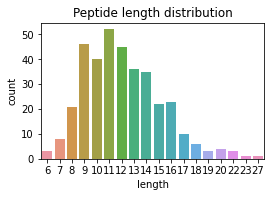

In [6]:
list(set(processed_data.sequence.str.len().tolist()))
f = plt.figure(figsize=(4,2.5))
ax = f.add_subplot(1,1,1)
length_dist = pd.DataFrame({'length': processed_data.sequence.str.len().value_counts().index,
                            'count': processed_data.sequence.str.len().value_counts()}).sort_values('length')
sns.barplot(data = length_dist, x = 'length', y = 'count')
ax.set_title("Peptide length distribution")

In [8]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


##### Split data in to train and test

In [5]:
train_df, test_df = train_test_split(key, processed_data) # 70% training, 30% testing
(train_df.shape), (test_df.shape) #359 total raw data points

((251, 18), (108, 18))

Note that this the num of train + test samples  = total graphs

## Deep learning related model of interests
- Sequence based models
    - One hot encoding with random forest
    - Unirep representation with random forest
- Graph based models
    - Massage passing neural network (MPNN)
    - Deep message passing neural network (DMPNN)
    - Deep graph attention neural network (DeepGAT)
- Sequence properties based models
    - Using SASA features to fit a linear model for Met oxi prediction
    - Using fluc features (AMN and NMA) to fit a linear model for Met oxi prediction, see `fluc_clinear_regression.ipynb`

##### According to the distribution graph above, pad it to length 30 is enough

In [6]:
train_oh = one_hot(train_df, 27) #pad sequence to 27 length and one hot encode it
test_oh = one_hot(test_df, 27)
print(train_oh.shape, test_oh.shape)

train_unirep = unirep_reps(train_df) # unirep representation of the sequence
test_unirep = unirep_reps(test_df)
print(train_unirep.shape, test_unirep.shape)

train_graph = graph_tensors(train_df, graphs) # use graph + sasa features + fluc features
test_graph = graph_tensors(test_df, graphs)

# get an idea of the output dim of graph_tensors
adjs, feats = graph_tensors(train_df, graphs)
print(adjs.shape, feats.shape) # adjs: (n_sample, n_node, n_node, 1), feats: (n_sample, n_node, n_feature)

(251, 567) (108, 567)
(251, 1900) (108, 1900)
(251, 20, 20, 1) (251, 20, 67)


In [7]:
#load target value
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

## Linear model of interests
- Use SASA to predict oxidation
- Use ANM to predict oxidation
- use NMA to predict oxidation

In [12]:
with open(here() / "data/ghesquire_2011/sasa.pkl", "rb") as f:
    sasa_dfs = pkl.load(f)
with open(here() / "data/ghesquire_2011/ANM.pkl", "rb") as f:
    anm_dfs = pkl.load(f)
with open(here() / "data/ghesquire_2011/NMA.pkl", "rb") as f:
    nma_dfs = pkl.load(f)

In [13]:
from sklearn.linear_model import LinearRegression
def linear_model_data_forsasa(df, sasa_dfs):
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        feats = sasa_dfs[acc].query("ResidNr == @pos")[["SASA/A^2", "N(overl)"]] #using only two features from sasa_dfs, want to compare with older models
        linear.append(feats)

    return pd.concat(linear)

def linear_model_data_for_anm_nma(df, feature_dfs):
    """
    return a feature vector 
    :params df: either train_df or test_df
    :params feature_df: either anm_dfs or nma_dfs, they are dictionaries
                        with key being accesssion and values being features associated
                        that accession number
    """
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        # preprocessing already removed all the inf and nan values, so in theory there shouldn't be any
        if feature_dfs[acc].loc[:,'fluc'].isnull().any().sum()!=0:
            feature_dfs[acc] = feature_dfs[acc].replace(np.inf, 100000000, inplace =True)
        feats = feature_dfs[acc].query("resnos == @pos")[["fluc"]]
        linear.append(feats)
    return pd.concat(linear)


In [14]:
linear_models = {
    "sasa": linear_model_data_forsasa(train_df, sasa_dfs), 
    "anm": linear_model_data_for_anm_nma(train_df, anm_dfs),
    "nma": linear_model_data_for_anm_nma(train_df, nma_dfs),
    "sasa_test": linear_model_data_forsasa(test_df, sasa_dfs), 
    "anm_test": linear_model_data_for_anm_nma(test_df, anm_dfs),
    "nma_test": linear_model_data_for_anm_nma(test_df, nma_dfs)
}

In [15]:
sasa_linear = LinearRegression().fit(linear_models['sasa'], train_target)
anm_linear = LinearRegression().fit(linear_models['anm'], train_target)
nma_linear = LinearRegression().fit(linear_models['nma'], train_target)

In [ ]:
#train_linear = linear_model_data(train_df, sasa_dfs)
#test_linear = linear_model_data(test_df, sasa_dfs)

In [ ]:
#from sklearn.linear_model import LinearRegression
#model_linear = LinearRegression()
#model_linear.fit(train_linear, train_target)

### Define training for non-linear models

In [8]:
num_training_steps = 5000
node_feature_shape = (20,67)
num_adjacency =1
deep_models = {
    "mpnn": MPNN(
        node_feature_shape=node_feature_shape,# (num_nodes is number of unique animo acid, num_feats from data/amino_acid_properties.csv + 4 sasa_dfs features +2 fluc features )
        num_adjacency=num_adjacency,
        num_training_steps=num_training_steps
    ),
    "deep_mpnn": DeepMPNN(
        node_feature_shape=node_feature_shape,
        num_adjacency=num_adjacency,
        num_training_steps=num_training_steps
    ),
    "deep_gat": DeepGAT(
        node_feature_shape = node_feature_shape,
        num_adjacency = num_adjacency,
        num_training_steps=num_training_steps
    )
}
rf_models =  {
    "rf_oh": RandomForestRegressor(n_estimators=300), #300 is set as default
    "rf_unirep": RandomForestRegressor(n_estimators=300)
}

## start training all models

In [31]:
for deep_model in deep_models.keys():
    print(f"training {deep_model} model now")
    deep_models[deep_model].fit(train_graph, train_target)

training mpnn model now


  0%|          | 0/5000 [00:00<?, ?it/s]

training deep_mpnn model now


  0%|          | 0/5000 [00:00<?, ?it/s]

training deep_gat model now


  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
model_rfoh = rf_models['rf_oh'].fit(train_oh, train_target)
model_rf_unirep = rf_models['rf_unirep'].fit(train_unirep, train_target)

In [35]:
deep_models["mpnn"].loss_history[:5]

[DeviceArray(30.723082, dtype=float32),
 DeviceArray(14.020044, dtype=float32),
 DeviceArray(25.584467, dtype=float32),
 DeviceArray(10.531688, dtype=float32),
 DeviceArray(4.7555356, dtype=float32)]

In [ ]:
## train gat model more

In [ ]:
deep_models["deep_gat"].fit(train_graph, train_target)

In [10]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])

def plot_performance(
    model,
    trainX, trainY, testX, testY,
    model_name: str,
    ev_func1,
    ev_func2,
    checkpoint: int = None,
):
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
    # evaluate model is MPNN class, b/c other deep learning models inhert from this class, they are all under this class
    if isinstance(model, MPNN):
        train_preds = model.predict(trainX, checkpoint=checkpoint)
    else:
        train_preds = model.predict(trainX)
    ax[0].scatter(trainY, train_preds.squeeze())
    ax[0].set_title(f"Model: {model_name}, Train evs: {ev_func1(trainY, train_preds.squeeze()):.3f},mse: {ev_func2(trainY, train_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[0])

    if isinstance(model, MPNN):
        test_preds = model.predict(testX, checkpoint=checkpoint)
    else:
        test_preds = model.predict(testX)
    ax[1].scatter(testY, test_preds.squeeze())
    ax[1].set_title(f"Model: {model_name}, Test evs: {ev_func1(testY, test_preds.squeeze()):.3f}, mse: {ev_func2(testY, test_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[1])

## Baseline Model Performance

#### linear models

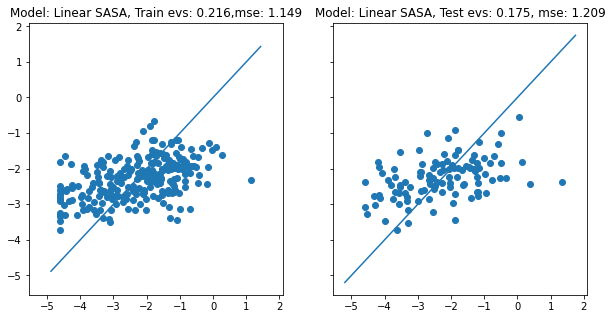

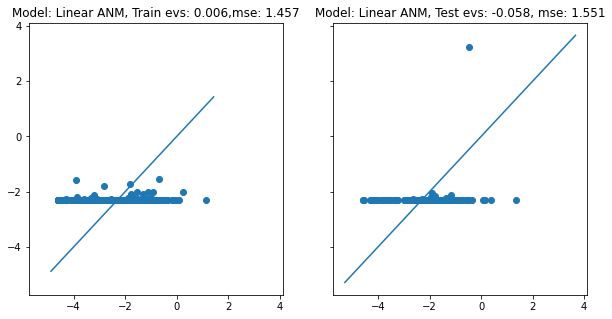

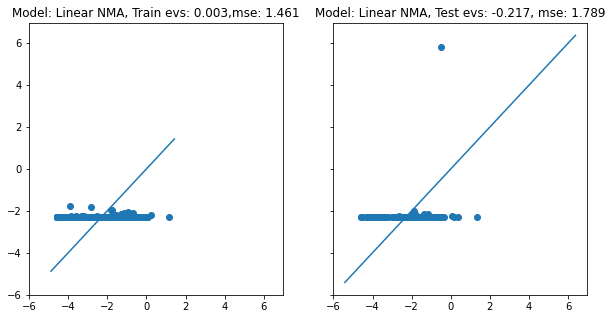

In [16]:
plot_performance(sasa_linear,linear_models['sasa'], train_target, linear_models['sasa_test'], test_target, 'Linear SASA', evs,mse)
plot_performance(anm_linear,linear_models['anm'], train_target, linear_models['anm_test'], test_target, 'Linear ANM', evs, mse)
plot_performance(nma_linear,linear_models['nma'], train_target, linear_models['nma_test'], test_target, 'Linear NMA', evs, mse)


### random forest models

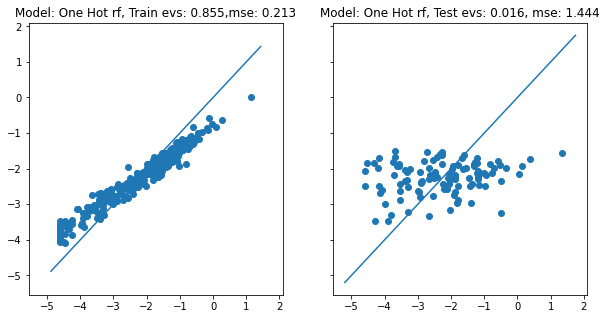

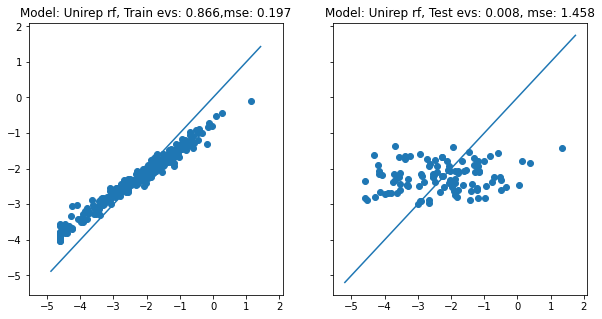

In [17]:
plot_performance(model_rfoh, train_oh, train_target, test_oh, test_target, 'One Hot rf', evs, mse)
plot_performance(model_rf_unirep, train_unirep, train_target, test_unirep, test_target, 'Unirep rf', evs, mse)

## Which checkpoint for NN models?

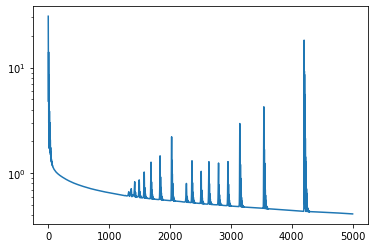

In [44]:
plt.plot(deep_models["mpnn"].loss_history)
plt.yscale("log")

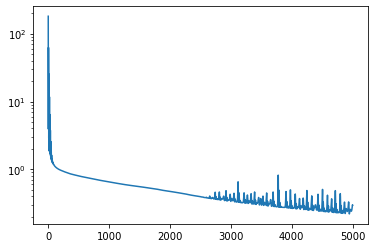

In [45]:
plt.plot(deep_models["deep_mpnn"].loss_history)
plt.yscale("log")

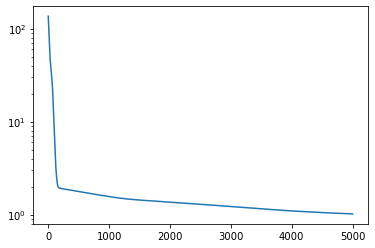

In [46]:
plt.plot(deep_models["deep_gat"].loss_history)
plt.yscale("log")

## Checkpoint at 400 steps

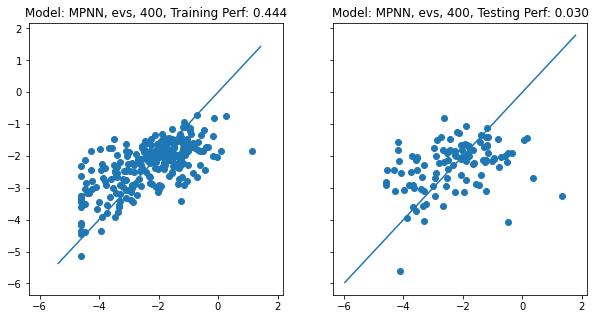

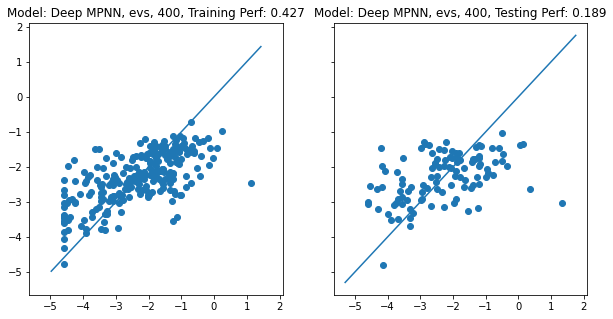

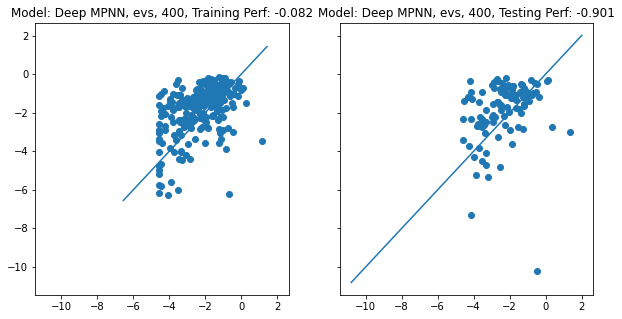

In [49]:
checkpoint = 400
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)

## Checkpoint at 600 steps

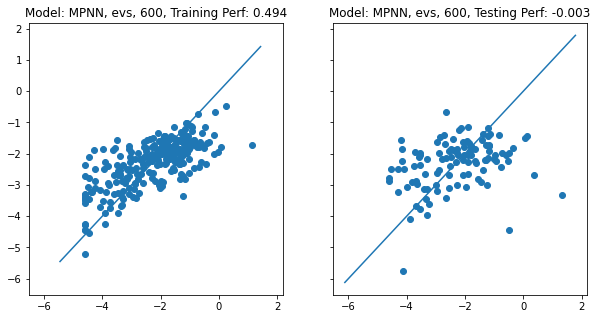

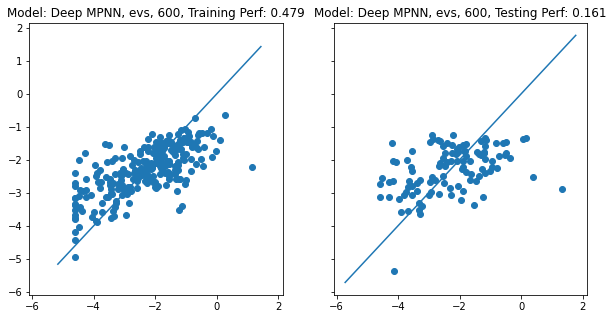

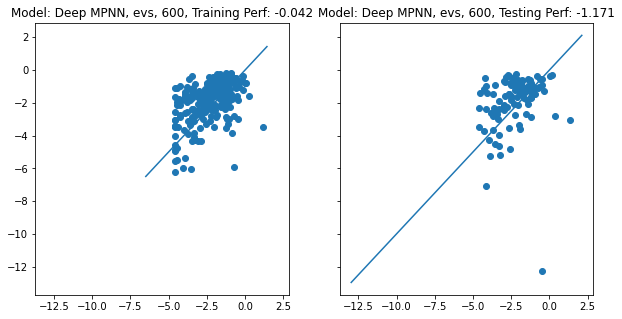

In [50]:
checkpoint = 600
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


In [54]:
isinstance(deep_models["deep_gat"], MPNN)

True

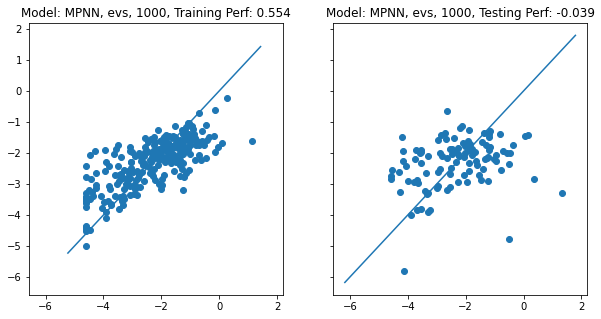

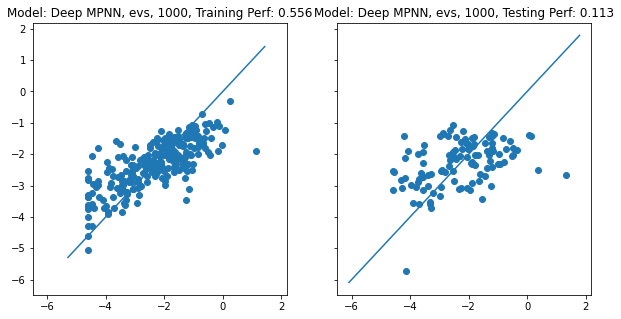

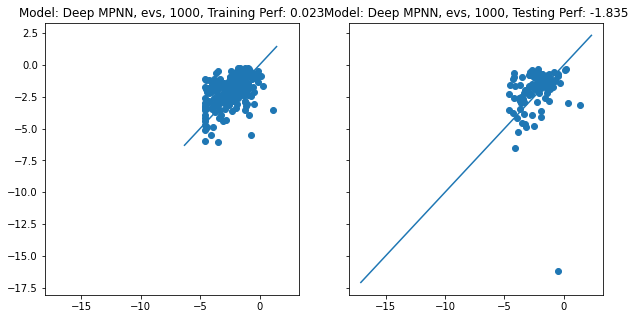

In [51]:
checkpoint = 1000
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


## Checkpoint at Final steps

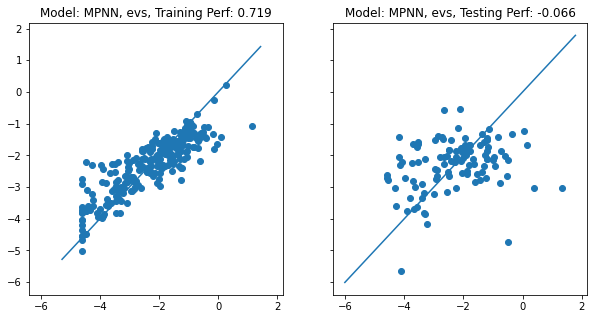

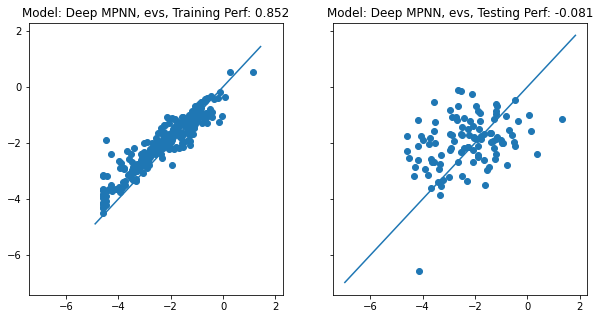

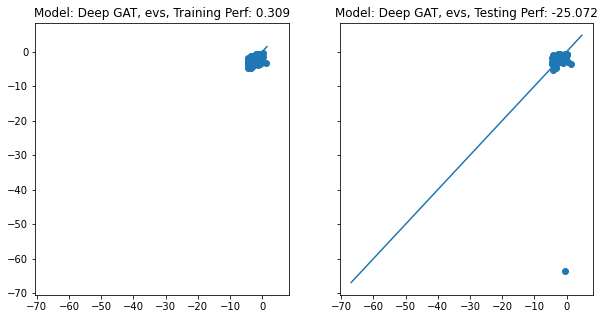

In [52]:
plot_performance(deep_models["mpnn"], train_graph, train_target, test_graph, test_target, f'MPNN, evs', evs, checkpoint=-1)
plot_performance(deep_models["deep_mpnn"], train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs',  evs, checkpoint=-1)
plot_performance(deep_models["deep_gat"], train_graph, train_target, test_graph, test_target, f'Deep GAT, evs', evs, checkpoint=-1)